### SBB

**Overview**

The SBB (Schweizerische Bundesbahnen)is the national railway company of Switzerland. It was founded in 1902 and is today one of the largest public transport companies in Switzerland. The SBB operates the majority of the Swiss railway network and provides passenger and freight transport services.
In Switzerland, the GA (Generalabonnement) and the Half-Fare travelcard are two very popular offers for public transportation, allowing travelers to utilize the extensive network of the Swiss Federal Railways (SBB) as well as many other modes of transport in the country.
The GA provides unlimited travel across the entire SBB network and most other railways in Switzerland. It is also valid for most postal buses, ships, buses, and even some mountain railways.
The Half-Fare is a discount card that grants travelers 50% off most train, bus, ship, and mountain railway fares within Switzerland.

**Research Question**

Can I predict the future sales of GA and Half Fare Travelcards in Switzerland for the upcoming years based on historical data?

**Data**

The dataset is publicly available:
https://opendata.swiss/en/dataset/ga-hta-liste

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.api import VAR
from sklearn import model_selection
import warnings
warnings.filterwarnings("ignore")

### Data Preprocessing


In [2]:
# Load the data
file_path = 'data/SBB.xlsx' 
data = pd.read_excel(file_path)

data.head()

,Jahr_An_Anno,PLZ_NPA,GA_AG,GA_AG_flag,HTA_ADT_meta-prezzo,HTA_ADT_meta-prezzo_flag
0,2012,1000,72.0,NaN,976.0,NaN
1,2012,1003,744.0,NaN,3195.0,NaN
2,2012,1004,1919.0,NaN,8167.0,NaN
3,2012,1005,860.0,NaN,4021.0,NaN
4,2012,1006,1279.0,NaN,5366.0,NaN


In [3]:
# Handling missing values (if any)
data = data.fillna({'GA_AG_flag': 0, 'HTA_ADT_meta-prezzo_flag': 0})

### Exploratory Data Analysis (EDA)

In [4]:
# Summary Statistics

# Generate descriptive statistics
summary_statistics = data.describe()

In [5]:
# Descriptives
summary_statistics

,Jahr_An_Anno,PLZ_NPA,GA_AG,GA_AG_flag,HTA_ADT_meta-prezzo,HTA_ADT_meta-prezzo_flag
count,35035.000000,35035.000000,35035.000000,35035.000000,35035.000000,35035.000000
mean,2016.993264,5116.135550,141.508766,0.330412,787.494891,0.071643
std,3.161864,2654.314463,342.953613,0.470368,1521.737306,0.371694
min,2012.000000,1000.000000,0.000000,0.000000,0.000000,0.000000
25%,2014.000000,2826.000000,10.284519,0.000000,102.000000,0.000000
50%,2017.000000,5046.000000,36.000000,0.000000,260.000000,0.000000
75%,2020.000000,7310.000000,113.000000,1.000000,739.500000,0.000000
max,2022.000000,9999.000000,4984.000000,1.000000,20330.000000,2.000000


In [6]:
# Number of different districts
data["PLZ_NPA"].nunique()

3194

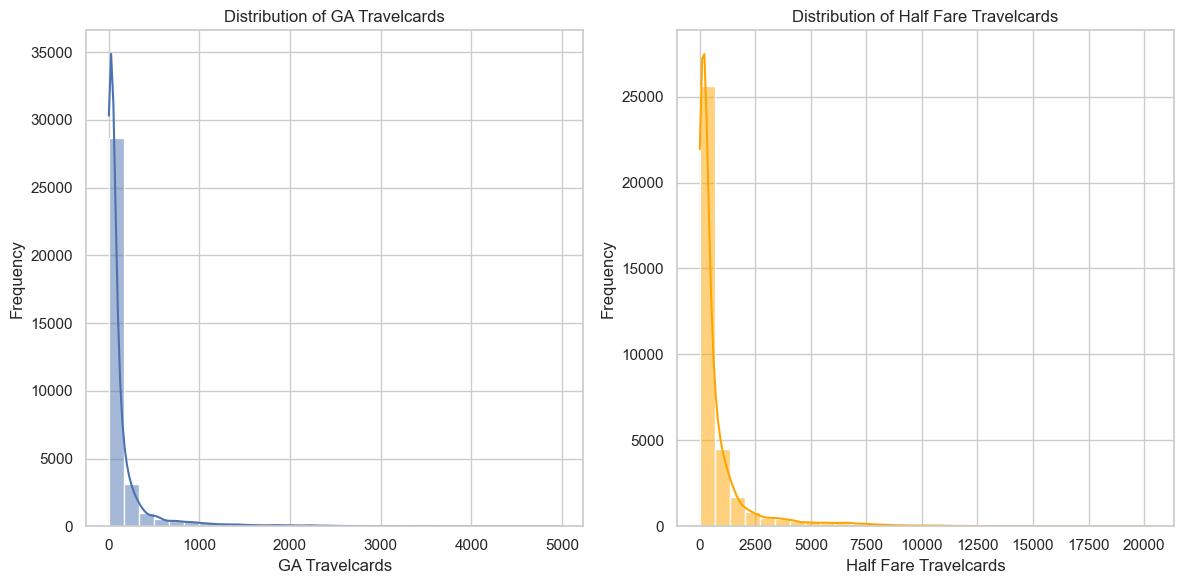

In [7]:
# Visualizing the Distribution of Travelcards

sns.set(style="whitegrid")

# Distribution of GA Travelcards
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['GA_AG'], bins=30, kde=True)
plt.title('Distribution of GA Travelcards')
plt.xlabel('GA Travelcards')
plt.ylabel('Frequency')

# Distribution of Half Fare Travelcards
plt.subplot(1, 2, 2)
sns.histplot(data['HTA_ADT_meta-prezzo'], bins=30, kde=True, color='orange')
plt.title('Distribution of Half Fare Travelcards')
plt.xlabel('Half Fare Travelcards')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


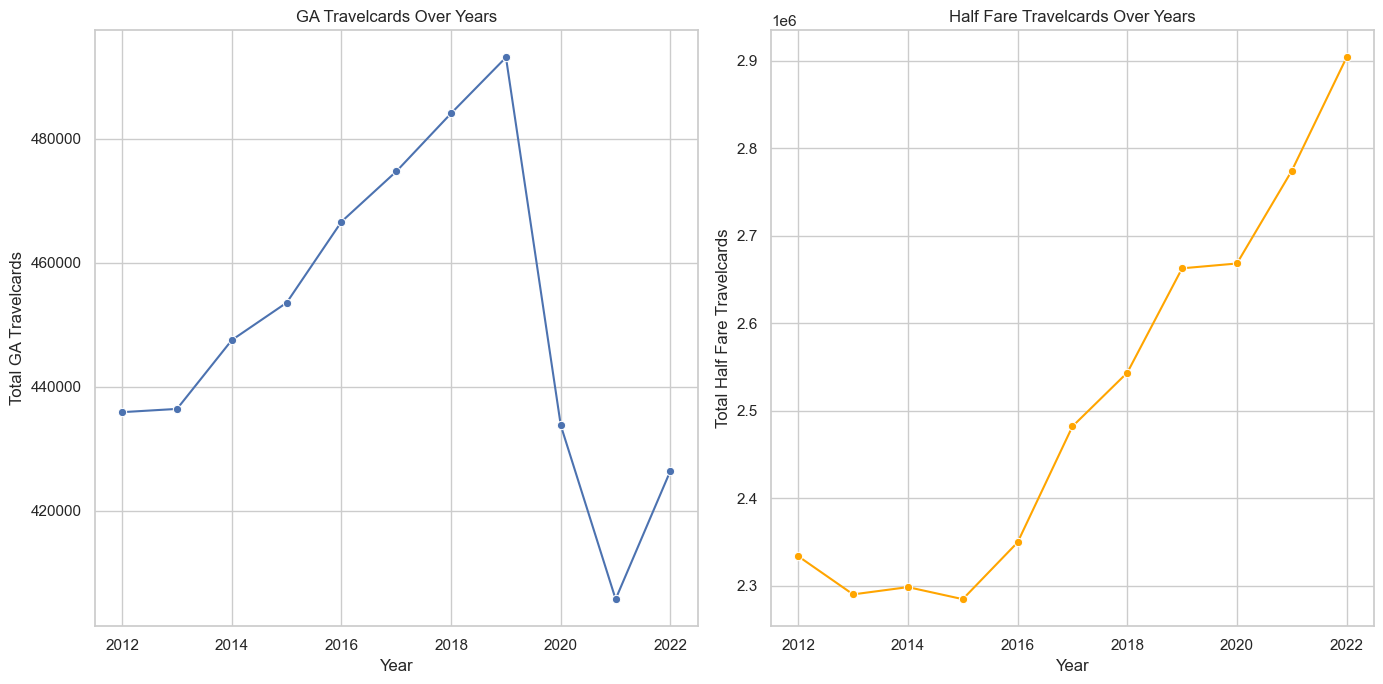

In [8]:
# Trends in travelcard sales over years
plt.figure(figsize=(14, 7))

# GA Travelcards over the years
plt.subplot(1, 2, 1)
yearly_ga = data.groupby('Jahr_An_Anno')['GA_AG'].sum().reset_index()
sns.lineplot(x='Jahr_An_Anno', y='GA_AG', data=yearly_ga, marker='o')
plt.title('GA Travelcards Over Years')
plt.xlabel('Year')
plt.ylabel('Total GA Travelcards')

# Half Fare Travelcards over the years
plt.subplot(1, 2, 2)
yearly_hta = data.groupby('Jahr_An_Anno')['HTA_ADT_meta-prezzo'].sum().reset_index()
sns.lineplot(x='Jahr_An_Anno', y='HTA_ADT_meta-prezzo', data=yearly_hta, marker='o', color='orange')
plt.title('Half Fare Travelcards Over Years')
plt.xlabel('Year')
plt.ylabel('Total Half Fare Travelcards')

plt.tight_layout()
plt.show()


Text(0.5, 0, 'District')

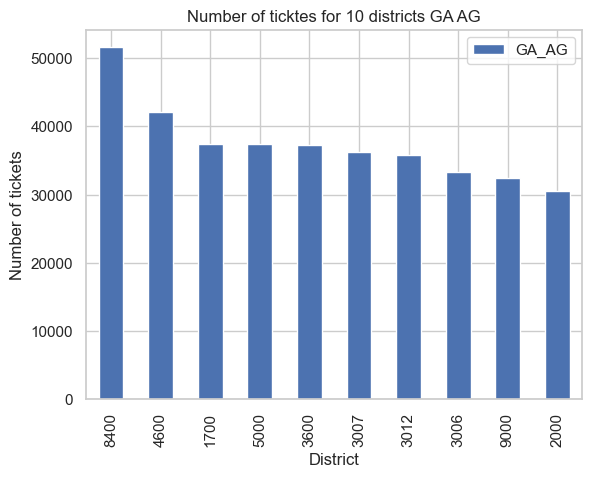

In [9]:
# Plot number of tickets for top 10 districts GA AG
top_10_districts = data.groupby("PLZ_NPA")["GA_AG"].sum().reset_index().sort_values("GA_AG", ascending=False).head(10)
top_10_districts = top_10_districts.set_index("PLZ_NPA")
top_10_districts.plot(kind="bar")
plt.title('Number of ticktes for 10 districts GA AG')
plt.ylabel('Number of tickets')
plt.xlabel('District')

Text(0.5, 0, 'District')

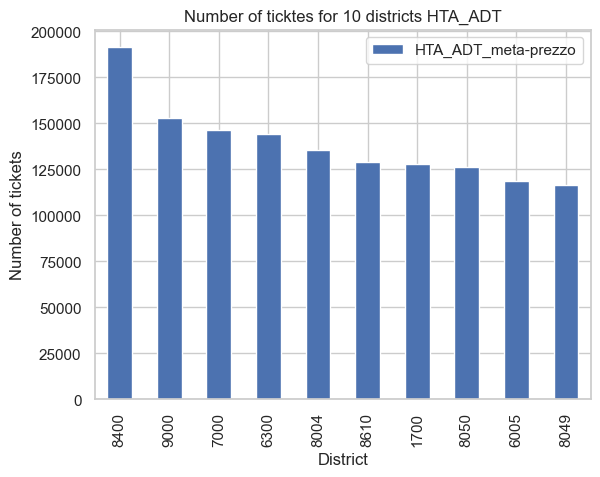

In [10]:
# Plot number of tickets for top 10 districts HTA_ADT
top_10_districts = data.groupby("PLZ_NPA")["HTA_ADT_meta-prezzo"].sum().reset_index().sort_values("HTA_ADT_meta-prezzo", ascending=False).head(10)
top_10_districts = top_10_districts.set_index("PLZ_NPA")
top_10_districts.plot(kind="bar")
plt.title('Number of ticktes for 10 districts HTA_ADT')
plt.ylabel('Number of tickets')
plt.xlabel('District')

Text(0.5, 1.0, 'Correlation Matrix of the variables')

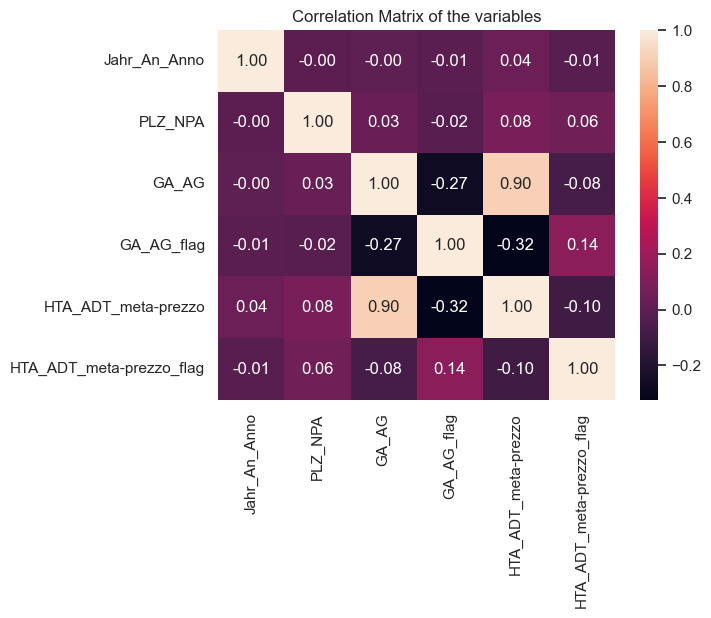

In [11]:
# PLot correlations
corr = data.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title('Correlation Matrix of the variables')

In [12]:
# Index year calculation
data['Year_Index'] = data['Jahr_An_Anno'] - data['Jahr_An_Anno'].min()

In [13]:
# Get categorical names for districts
data_dummies = pd.get_dummies(data["PLZ_NPA"])

In [14]:
# Rename columns to strings
data_dummies.columns = data_dummies.columns.astype(str)

In [15]:
# Merge with existing dataset
data = pd.concat([data, data_dummies], axis=1)

### Model Selection and Training

In [16]:
# District selection
data = data[["Jahr_An_Anno", "PLZ_NPA", "GA_AG", "GA_AG_flag", "HTA_ADT_meta-prezzo", "HTA_ADT_meta-prezzo_flag", "8400", "4600",
             "1700", "5000", "3600", "3007", "3012", "3006", "9000", "2000"]]

In [17]:
# Preparing the features and targets
X = data.drop(columns=["GA_AG", "HTA_ADT_meta-prezzo", "PLZ_NPA"])
y_ga = data['GA_AG']  # Target for GA Travelcards
y_hta = data['HTA_ADT_meta-prezzo']  # Target for Half Fare Travelcards

# Splitting the dataset for GA Travelcards
X_train_ga, X_test_ga, y_train_ga, y_test_ga = train_test_split(X, y_ga, test_size=0.2, random_state=42)

# Splitting the dataset for Half Fare Travelcards
X_train_hta, X_test_hta, y_train_hta, y_test_hta = train_test_split(X, y_hta, test_size=0.2, random_state=42)

# Training and evaluating models for GA Travelcards
lr_model_ga = LinearRegression().fit(X_train_ga, y_train_ga)
rf_model_ga = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_ga, y_train_ga)
xgb_model_ga = XGBRegressor().fit(X_train_ga, y_train_ga)

y_pred_lr_ga = lr_model_ga.predict(X_test_ga)
y_pred_rf_ga = rf_model_ga.predict(X_test_ga)
y_pred_xgb_ga = xgb_model_ga.predict(X_test_ga)

mse_lr_ga = mean_squared_error(y_test_ga, y_pred_lr_ga)
mse_rf_ga = mean_squared_error(y_test_ga, y_pred_rf_ga)
mse_xgb_ga = mean_squared_error(y_test_ga, y_pred_xgb_ga)

# Training and evaluating models for Half Fare Travelcards
lr_model_hta = LinearRegression().fit(X_train_hta, y_train_hta)
rf_model_hta = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_hta, y_train_hta)
xgb_model_hta = XGBRegressor().fit(X_train_hta, y_train_hta)

y_pred_lr_hta = lr_model_hta.predict(X_test_hta)
y_pred_rf_hta = rf_model_hta.predict(X_test_hta)
y_pred_xgb_hta = xgb_model_hta.predict(X_test_hta)

mse_lr_hta = mean_squared_error(y_test_hta, y_pred_lr_hta)
mse_rf_hta = mean_squared_error(y_test_hta, y_pred_rf_hta)
mse_xgb_hta = mean_squared_error(y_test_hta, y_pred_xgb_hta)

### Model Evaluation

In [18]:
# Define a function to calculate MAE and MSE
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} on {dataset_name}:")
    print(f"Mean Absolute Error (MAE): {round(mae, 2)}")
    print(f"Root Mean Squared Error (MSE): {round(mse, 2)}\n")

# Evaluating models for GA Travelcards
evaluate_model(y_test_ga, y_pred_lr_ga, 'Linear Regression', 'GA Travelcards')
evaluate_model(y_test_ga, y_pred_rf_ga, 'Random Forest', 'GA Travelcards')
evaluate_model(y_test_ga, y_pred_xgb_ga, 'XGB', 'GA Travelcards')

# Evaluating models for Half Fare Travelcards
evaluate_model(y_test_hta, y_pred_lr_hta, 'Linear Regression', 'Half Fare Travelcards')
evaluate_model(y_test_hta, y_pred_rf_hta, 'Random Forest', 'Half Fare Travelcards')
evaluate_model(y_test_hta, y_pred_xgb_hta, 'XGB', 'GA Travelcards')

print("--------------------------------------------------------------")
print("Cross validation results:")

# Define scoring
scoring = {'mse': make_scorer(mean_squared_error),
           'mae': make_scorer(mean_absolute_error)}

# Cross validation function
def score_cross_validation(model, x_train, y_train,  model_name, dataset_name):
    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    cv_results = model_selection.cross_validate(model, x_train, y_train, cv=kfold, scoring=scoring)
    print(f"{model_name} on {dataset_name}:")
    print("Mean Absolute Error (MAE): " + str(round(cv_results["test_mae"].mean(), 2)))
    print("Root Mean Squared Error (MSE): " + str(round(cv_results["test_mse"].mean(), 2)))
    print("")
    
# Cross validation
score_cross_validation(lr_model_ga, X_train_ga, y_train_ga, 'Linear Regression', 'GA Travelcards')
score_cross_validation(rf_model_ga, X_train_ga, y_train_ga, 'Random Forest', 'GA Travelcards')
score_cross_validation(xgb_model_ga, X_train_ga, y_train_ga, 'XGB', 'GA Travelcards')

score_cross_validation(lr_model_hta, X_train_hta, y_train_hta, 'Linear Regression', 'GA Travelcards')
score_cross_validation(rf_model_hta, X_train_hta, y_train_hta, 'Random Forest', 'GA Travelcards')
score_cross_validation(xgb_model_hta, X_train_hta, y_train_hta, 'XGB', 'GA Travelcards')

Linear Regression on GA Travelcards:
Mean Absolute Error (MAE): 131.69
Root Mean Squared Error (MSE): 78070.64

Random Forest on GA Travelcards:
Mean Absolute Error (MAE): 127.87
Root Mean Squared Error (MSE): 77657.28

XGB on GA Travelcards:
Mean Absolute Error (MAE): 127.96
Root Mean Squared Error (MSE): 77716.73

Linear Regression on Half Fare Travelcards:
Mean Absolute Error (MAE): 705.59
Root Mean Squared Error (MSE): 1830343.93

Random Forest on Half Fare Travelcards:
Mean Absolute Error (MAE): 684.82
Root Mean Squared Error (MSE): 1819222.06

XGB on GA Travelcards:
Mean Absolute Error (MAE): 685.4
Root Mean Squared Error (MSE): 1819871.25

--------------------------------------------------------------
Cross validation results:
Linear Regression on GA Travelcards:
Mean Absolute Error (MAE): 131.02
Root Mean Squared Error (MSE): 75395.76

Random Forest on GA Travelcards:
Mean Absolute Error (MAE): 127.6
Root Mean Squared Error (MSE): 74969.3

XGB on GA Travelcards:
Mean Absolute E

In [19]:
# Districts with year 2022
districts_with_2022 = data[data["Jahr_An_Anno"] == 2022]["PLZ_NPA"].unique()

In [20]:
# Districts with unsufficient data
districts_with_unsuficient_data = data["PLZ_NPA"].value_counts().tail(21).index

In [21]:
# List of all districts that have 11 years of data
districts_with_2022 = list(set(districts_with_2022) - set(districts_with_unsuficient_data))

In [22]:
# VAR model creation and evaluation and grid search for optimal order
optional_orders = [1,2,3,4,5]
MAE_ga = 0
MAE_hta = 0
MSE_ga = 0
MSE_hta = 0
for order in optional_orders:
    for district in districts_with_2022:
        # Chose the specifit disttirct
        VAR_data = data[data["PLZ_NPA"] == district][["Jahr_An_Anno", "GA_AG", "HTA_ADT_meta-prezzo"]]
        
        # Remove the last year for testing
        VAR_data_2021 = VAR_data[:-1]

        # Train VAR model
        model = VAR(VAR_data_2021)
        model_fitted = model.fit(order)

        # Forecast
        forecast = model_fitted.forecast(model_fitted.endog, steps=1)

        # Convert the forecast results to a DataFrame
        forecast_df = pd.DataFrame(forecast, columns=VAR_data.columns)

        MAE_ga = MAE_ga + abs(forecast_df["GA_AG"] - VAR_data[VAR_data["Jahr_An_Anno"] == 2022]["GA_AG"].values[0])[0]
        MAE_hta = MAE_hta + abs(forecast_df["HTA_ADT_meta-prezzo"] - VAR_data[VAR_data["Jahr_An_Anno"] == 2022]["HTA_ADT_meta-prezzo"].values[0])[0]

        MSE_ga = MSE_ga + (abs(forecast_df["GA_AG"] - VAR_data[VAR_data["Jahr_An_Anno"] == 2022]["GA_AG"].values[0])[0])**2
        MSE_hta = MSE_hta + (abs(forecast_df["HTA_ADT_meta-prezzo"] - VAR_data[VAR_data["Jahr_An_Anno"] == 2022]["HTA_ADT_meta-prezzo"].values[0])[0])**2

    # MAE calculation
    MAE_ga = MAE_ga / len(districts_with_2022)
    MAE_hta = MAE_hta / len(districts_with_2022)
    
    # MSE calculation
    MSE_ga = np.sqrt(MSE_ga / len(districts_with_2022))
    MSE_hta = np.sqrt(MSE_hta / len(districts_with_2022))
    
    # Evaluation of the results
    print("Order: " + str(order))
    print(f'GA Travelcards - VAR MAE: {round(MAE_ga, 2)}, MSE: {round(MSE_ga, 2)}')
    print(f'Half Fare Travelcards - VAR MAE: {round(MAE_hta, 2)}, MSE: {round(MSE_hta, 2)}')
    print("-----------------------------------------------------------")

Order: 1
GA Travelcards - VAR MAE: 18.92, MSE: 54.97
Half Fare Travelcards - VAR MAE: 29.03, MSE: 70.93
-----------------------------------------------------------
Order: 2
GA Travelcards - VAR MAE: 50.48, MSE: 200.52
Half Fare Travelcards - VAR MAE: 93.69, MSE: 319.65
-----------------------------------------------------------
Order: 3
GA Travelcards - VAR MAE: 231.41, MSE: 2464.08
Half Fare Travelcards - VAR MAE: 834.27, MSE: 14125.43
-----------------------------------------------------------
Order: 4
GA Travelcards - VAR MAE: 29.43, MSE: 93.9
Half Fare Travelcards - VAR MAE: 76.66, MSE: 233.88
-----------------------------------------------------------
Order: 5
GA Travelcards - VAR MAE: 18.21, MSE: 49.05
Half Fare Travelcards - VAR MAE: 48.48, MSE: 155.17
-----------------------------------------------------------


In [23]:
# Example prediction for a single district
input_district = 8400

VAR_data = data[data["PLZ_NPA"] == input_district][["Jahr_An_Anno", "GA_AG", "HTA_ADT_meta-prezzo"]]

# Train VAR model
model = VAR(VAR_data)
model_fitted = model.fit()

# Forecast
forecast = model_fitted.forecast(model_fitted.endog, steps=1)

# Convert the forecast results to a DataFrame
forecast_df = pd.DataFrame(forecast, columns=VAR_data.columns)

# Example predictions
future_prediction = pd.concat([data[data["PLZ_NPA"] == input_district][["Jahr_An_Anno", "GA_AG", "HTA_ADT_meta-prezzo"]], forecast_df]).reset_index(drop=True)

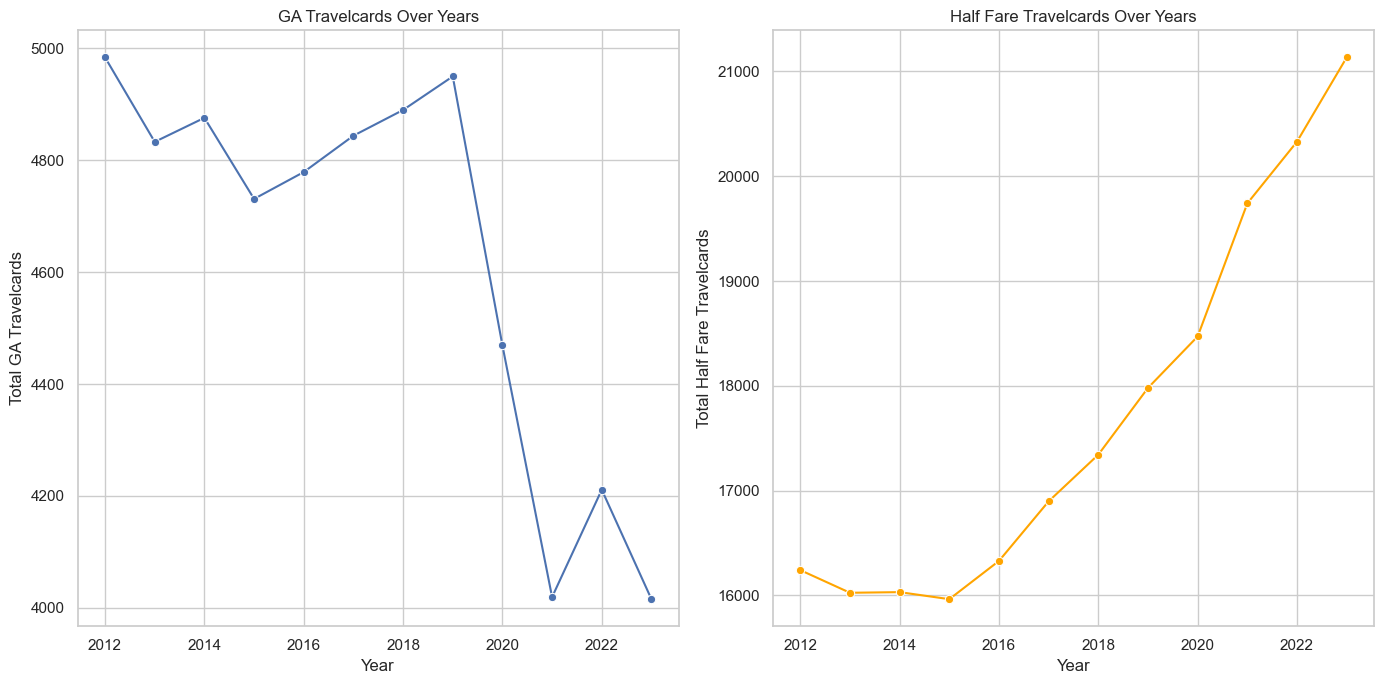

In [24]:
# Future visualisation for a specific district
# Trends in travelcard sales over years
plt.figure(figsize=(14, 7))

# GA Travelcards over the years
plt.subplot(1, 2, 1)
sns.lineplot(x='Jahr_An_Anno', y='GA_AG', data=future_prediction, marker='o')
plt.title('GA Travelcards Over Years')
plt.xlabel('Year')
plt.ylabel('Total GA Travelcards')

# Half Fare Travelcards over the years
plt.subplot(1, 2, 2)
sns.lineplot(x='Jahr_An_Anno', y='HTA_ADT_meta-prezzo', data=future_prediction, marker='o', color='orange')
plt.title('Half Fare Travelcards Over Years')
plt.xlabel('Year')
plt.ylabel('Total Half Fare Travelcards')

plt.tight_layout()
plt.show()